In [1]:
import os;
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.llms import OpenAI, Cohere
from langchain_openai import ChatOpenAI

In [2]:
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT="CRAG using langgraph"
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")  
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_TRACING_V2=True
SERPAPI_API_KEY=os.getenv("SERPAPI_API_KEY")

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

In [4]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [5]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]


In [6]:
type(docs), len(docs), len(docs_list)

(list, 3, 3)

In [7]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)


c:\Users\WIN-10\anaconda3\Lib\site-packages\opentelemetry\proto\collector\trace\v1\trace_service_pb2_grpc.py:26: RuntimeWarning: The grpc package installed is at version 1.63.0, but the generated code in opentelemetry/proto/collector/trace/v1/trace_service_pb2_grpc.py depends on grpcio>=1.63.2. Please upgrade your grpc module to grpcio>=1.63.2 or downgrade your generated code using grpcio-tools<=1.63.0. This warning will become an error in 1.65.0, scheduled for release on June 25, 2024.
  warnings.warn(


In [8]:
retriever = vectorstore.as_retriever()

In [23]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [20]:
docs

[Document(page_content='They also discussed the risks, especially with illicit drugs and bioweapons. They developed a test set containing a list of known chemical weapon agents and asked the agent to synthesize them. 4 out of 11 requests (36%) were accepted to obtain a synthesis solution and the agent attempted to consult documentation to execute the procedure. 7 out of 11 were rejected and among these 7 rejected cases, 5 happened after a Web search while 2 were rejected based on prompt only.\nGenerative Agents Simulation#\nGenerative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, each controlled by a LLM-powered agent, are living and interacting in a sandbox environment, inspired by The Sims. Generative agents create believable simulacra of human behavior for interactive applications.\nThe design of generative agents combines LLM with memory, planning and reflection mechanisms to enable agents to behave conditioned on past experience, as well as to int

In [28]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)



# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

c:\Users\WIN-10\anaconda3\Lib\site-packages\langchain\hub.py:86: DeprecationWarning: The `langchainhub sdk` is deprecated.
Please use the `langsmith sdk` instead:
  pip install langsmith
Use the `pull_prompt` method.
  res_dict = client.pull_repo(owner_repo_commit)


The agent system overview includes memory as a key component, with short-term memory for in-context learning and long-term memory for retaining and recalling information over extended periods. Long-term memory leverages an external vector store for fast retrieval, enhancing the agent's capabilities. The agent also learns to use external APIs for additional information not present in its model weights.


In [29]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is the role of memory in artificial intelligence agents?'

In [30]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [31]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [32]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [33]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [34]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The different categories of memory in agents are short-term memory and '
 'long-term memory. Short-term memory is utilized for in-context learning, '
 'while long-term memory allows agents to retain and recall information over '
 'extended periods. Memory management in AI agents is crucial for optimizing '
 'performance and enhancing user interactions.')


In [35]:
from pprint import pprint

# Run
inputs = {"question": "How does the AlphaCodium paper work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The AlphaCodium paper functions by proposing a test-based, multi-stage, '
 'code-oriented iterative flow to enhance the performance of Large Language '
 'Models on code problems. Its key mechanisms involve generating additional '
 'data like problem reflection and test reasoning, enriching the code '
 'generation process, and following a test-driven approach to optimize LLM '
 'code generation capabilities. AlphaCodium aims to improve LLM code '
 'generation by iterating on

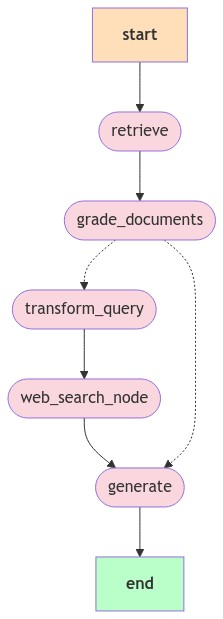

In [37]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 2, "score_threshold": 0.6})